In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops
from tensorflow.keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Task 1: Utilise Libraries/Dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#print(f"x_train: {x_train}")
print(f"y_train: {y_train}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
y_train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


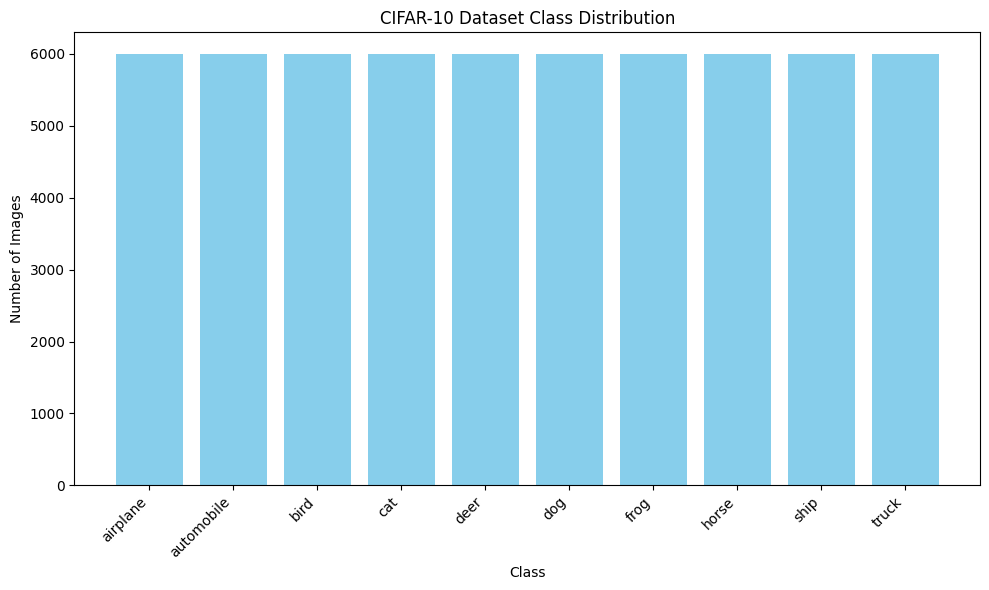

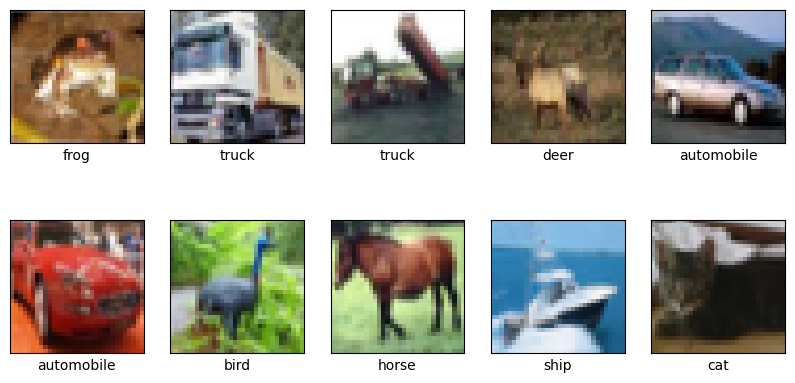

In [3]:
#Task 2: Generate at least two EDA visualisations

#Distribution by class
# Combine training and testing labels for the full dataset distribution
full_labels = np.concatenate((y_train, y_test), axis=0)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
unique_classes, counts = np.unique(full_labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('CIFAR-10 Dataset Class Distribution')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
#From the plot it appears that images are balanced in the dataset
#Print few images
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(labels[y_train[i][0]])
plt.show()


In [4]:
#Task 3: Analyse data quality
#!pip install cleanlab
import torch
#import torchvision
#import timm
#from cleanlab.outlier import OutOfDistribution
#from cleanlab.rank import find_top_issues

print(np.isnan(x_train).any())
print(np.isnan(x_test).any())



False
False


In [11]:
# Task 4: Construct a CNN model
num_classes = 10
input_shape = (32, 32, 3)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(Conv2D(12, 3, activation="relu"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(12, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add( Dropout(0.2) )
    model.add(Dense(10, kernel_initializer='normal', activation="softmax"))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

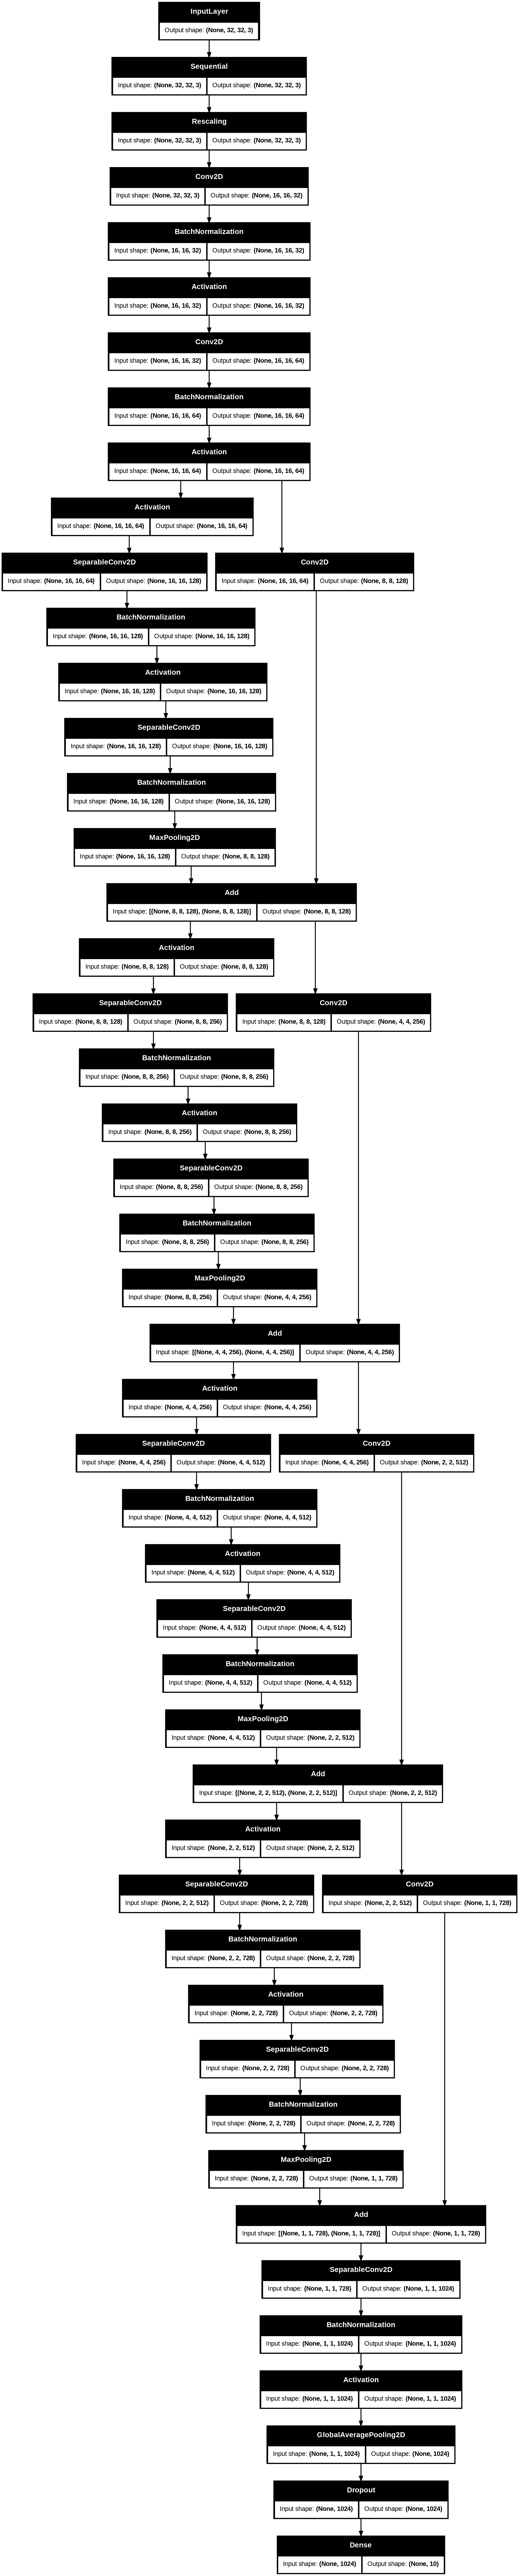

In [6]:
#Task 5: Train the CNN model using the CIFAR-10 dataset

model = make_model(input_shape=input_shape, num_classes=num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
#Task 6: Display model architecture and training progress
keras.utils.plot_model(model, show_shapes=True)



In [7]:
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - accuracy: 0.3563 - loss: 1.7829 - val_accuracy: 0.2309 - val_loss: 3.5924
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.4914 - loss: 1.4232 - val_accuracy: 0.4846 - val_loss: 1.4344
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5440 - loss: 1.2948 - val_accuracy: 0.5281 - val_loss: 1.4131
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.5943 - loss: 1.1599 - val_accuracy: 0.5951 - val_loss: 1.1307
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6219 - loss: 1.0735 - val_accuracy: 0.6126 - val_loss: 1.2296
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6513 - loss: 1.0032 - val_accuracy: 0.6574 - val_loss: 1.0310
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6716 - loss: 0.9467 - val_accuracy: 0.6447 - val_loss: 1.0902
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6880 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


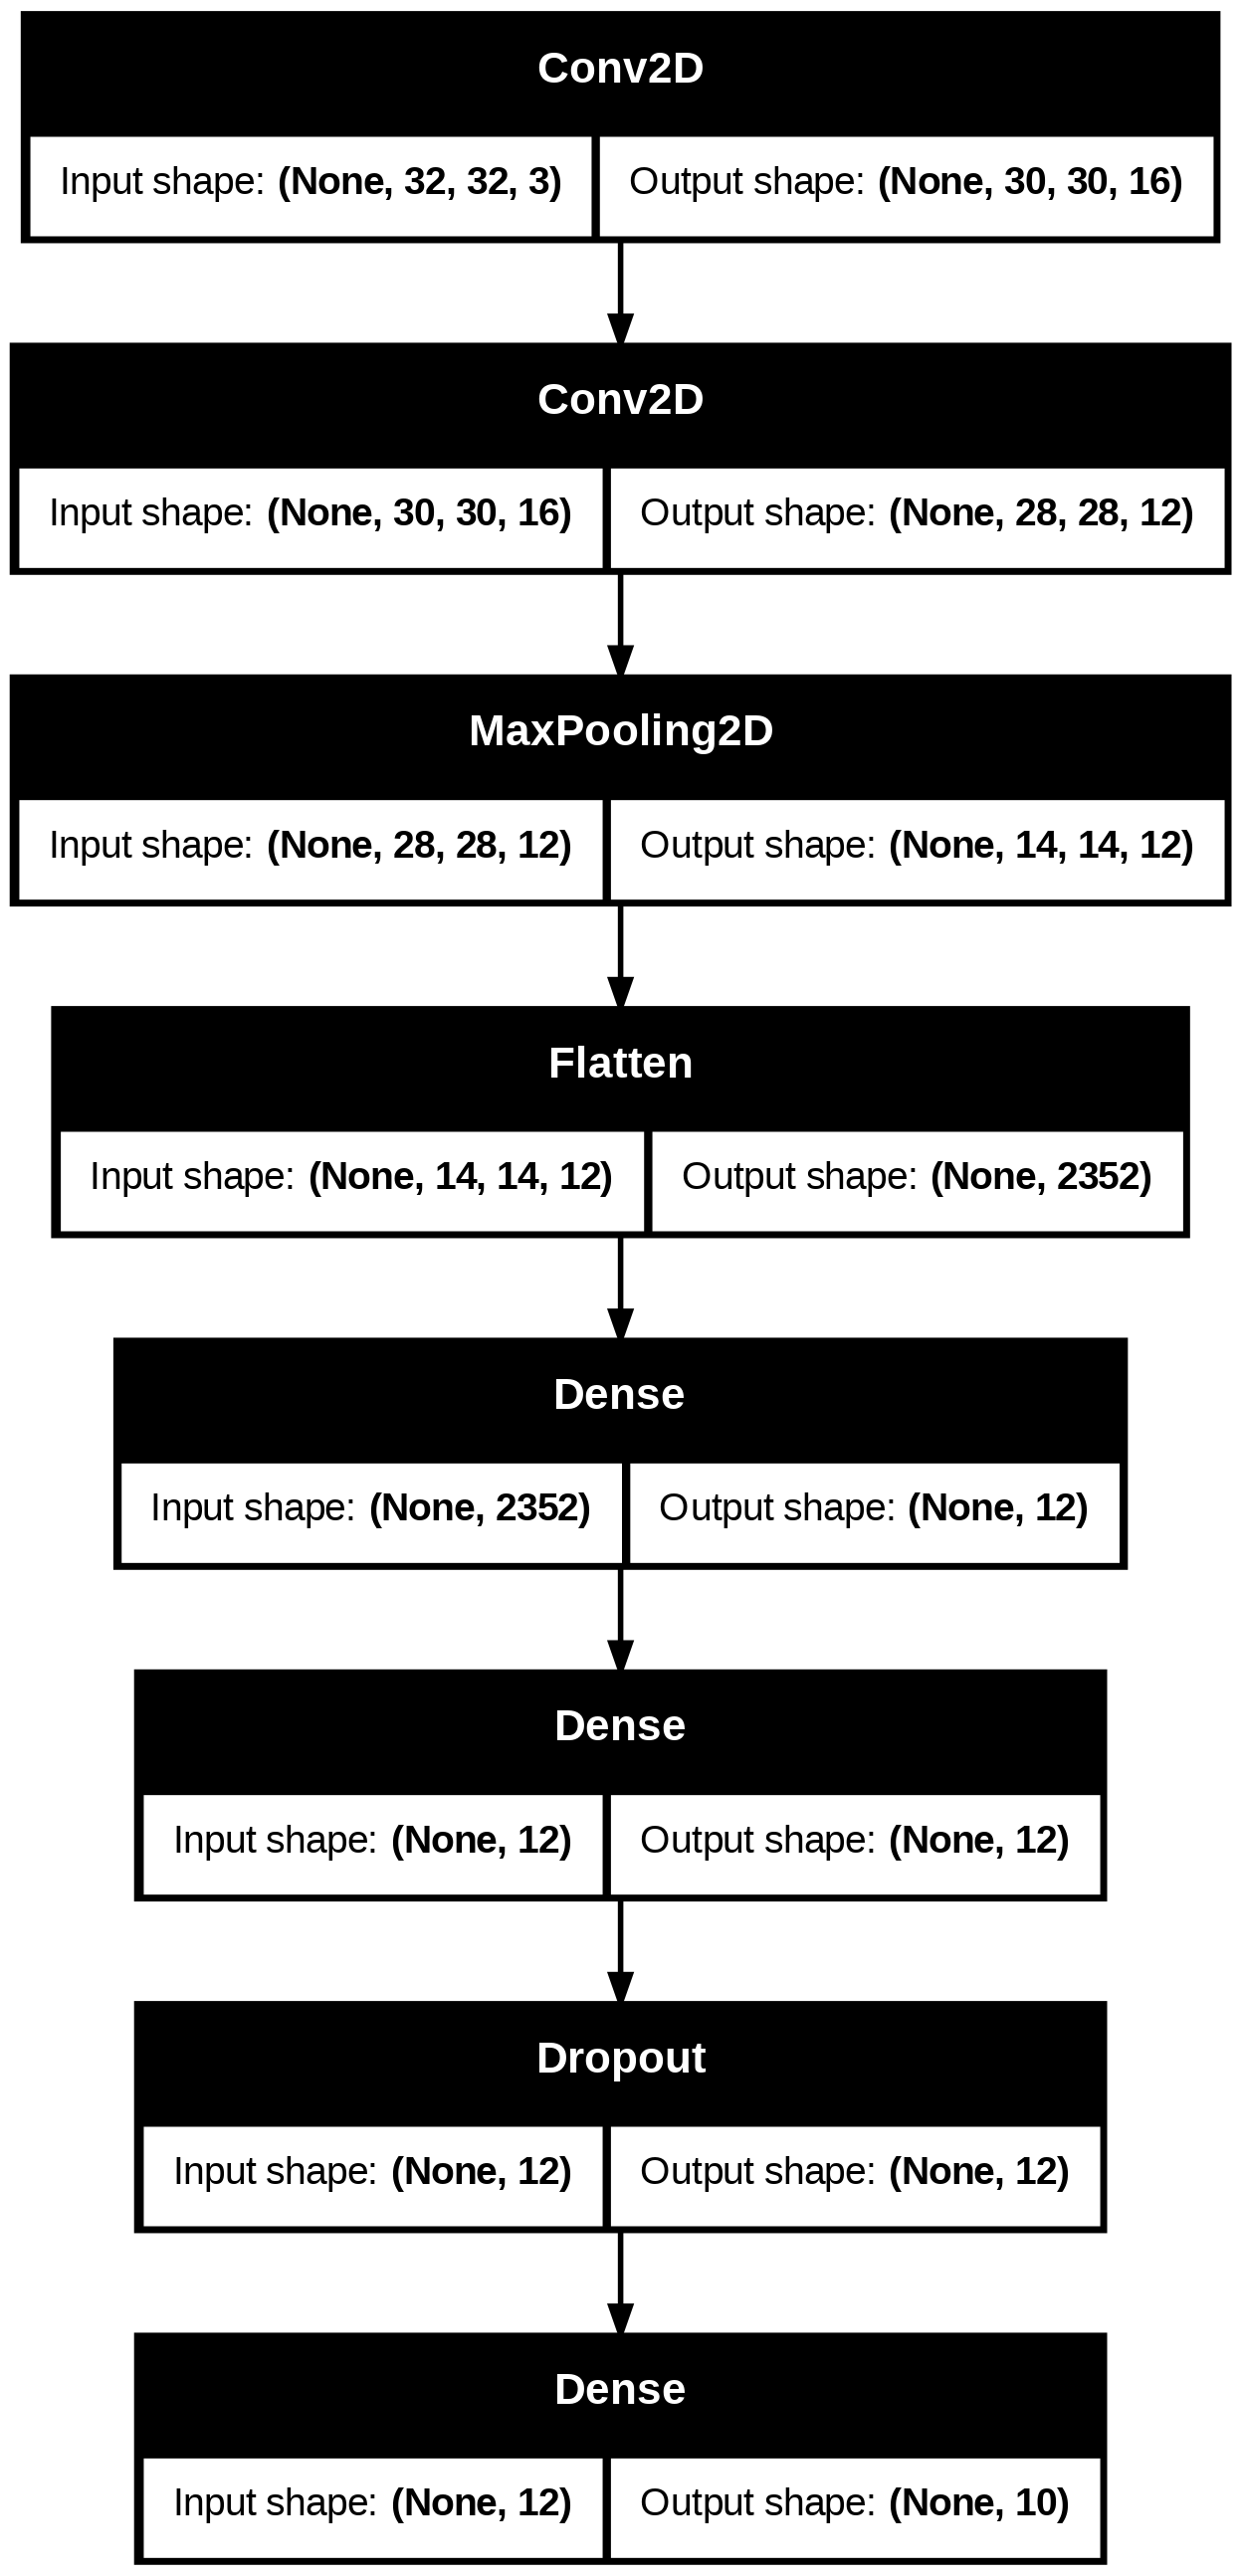

In [16]:
model1 = baseline_model()
model1.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
#Task 6: Display model architecture and training progress
keras.utils.plot_model(model, show_shapes=True)

In [17]:
model1.fit(x_train, y_train, epochs=10, verbose=2)

Epoch 1/10
1563/1563 - 10s - 6ms/step - accuracy: 0.1009 - loss: 2.3033
Epoch 2/10
1563/1563 - 4s - 2ms/step - accuracy: 0.0977 - loss: 2.3028
Epoch 3/10
1563/1563 - 4s - 3ms/step - accuracy: 0.0985 - loss: 2.3028
Epoch 4/10
1563/1563 - 5s - 3ms/step - accuracy: 0.0980 - loss: 2.3028
Epoch 5/10
1563/1563 - 4s - 3ms/step - accuracy: 0.0974 - loss: 2.3028
Epoch 6/10
1563/1563 - 5s - 3ms/step - accuracy: 0.0973 - loss: 2.3028
Epoch 7/10
1563/1563 - 5s - 3ms/step - accuracy: 0.0980 - loss: 2.3028
Epoch 8/10
1563/1563 - 4s - 3ms/step - accuracy: 0.0977 - loss: 2.3028
Epoch 9/10
1563/1563 - 6s - 4ms/step - accuracy: 0.0976 - loss: 2.3028
Epoch 10/10
1563/1563 - 4s - 3ms/step - accuracy: 0.0978 - loss: 2.3028
